# Xceptionの概要
Xception(Xetreme Inception)はGoogLeNetの改良版で, Iamge Net dataset(ILSVRCのデータ)でerror率5.5%のモデルである. GoogLeNetで用いられたInceptionはチャネルを分割してConvolutionに入力していた. これは空間情報と深さ(チャネル)情報がある程度分離して扱えることを意味している(Inception仮説). XceptionはInceptionの"ある程度"の分離を完全(Extreme)に分離する手法を採用している. これによって通常のConvolutionモデルと比較して約1/10のパラメータ数を実現している.

Xceptionモデルは次に示すようなモデルである(論文から引用). ここで各Separatable Convは次に示すような構造をしている.

![Xception-Architecture](./Xception-Architecture.png) 


![Separatable-Conv](./Separatable-Conv.png) 

# CIFAR-10による検証(転移学習)
Xceptionモデルを用いてCIFAR-10の転移学習を行う.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load CIFAR-10
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255
y_train = to_categorical(y_train)

x_test = x_test.astype('float32') / 255
y_test = to_categorical(y_test)

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=10000)

In [3]:
import keras
import tensorflow as tf
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,Input

# base model(Xception)を読み込み
# include_top : 出力層側の3つのDenseを含むかどうか
base_model =  tf.keras.applications.xception.Xception(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

# base modelに出力層を追加
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation="relu")(x)
prediction=Dense(10,activation='softmax')(x)
model=Model(inputs=base_model.input,outputs=prediction)
    
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer="adam",
    metrics=["accuracy"]
)

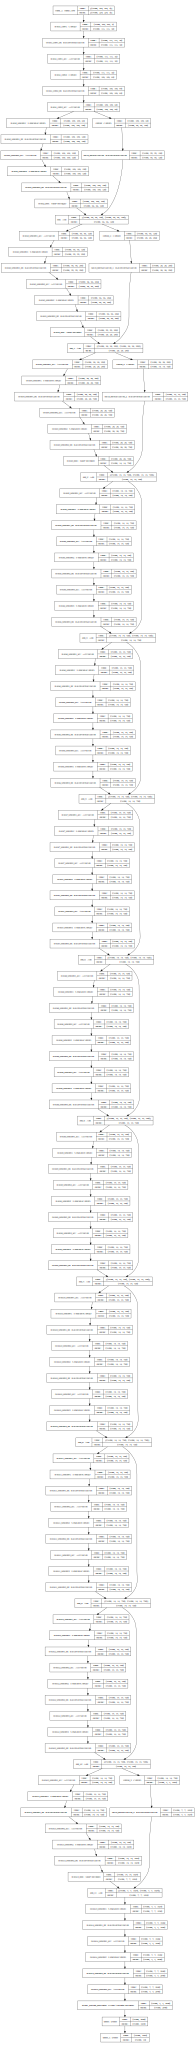

In [5]:
SVG(model_to_dot(model, show_shapes=True, dpi=None).create(prog='dot', format='svg'))

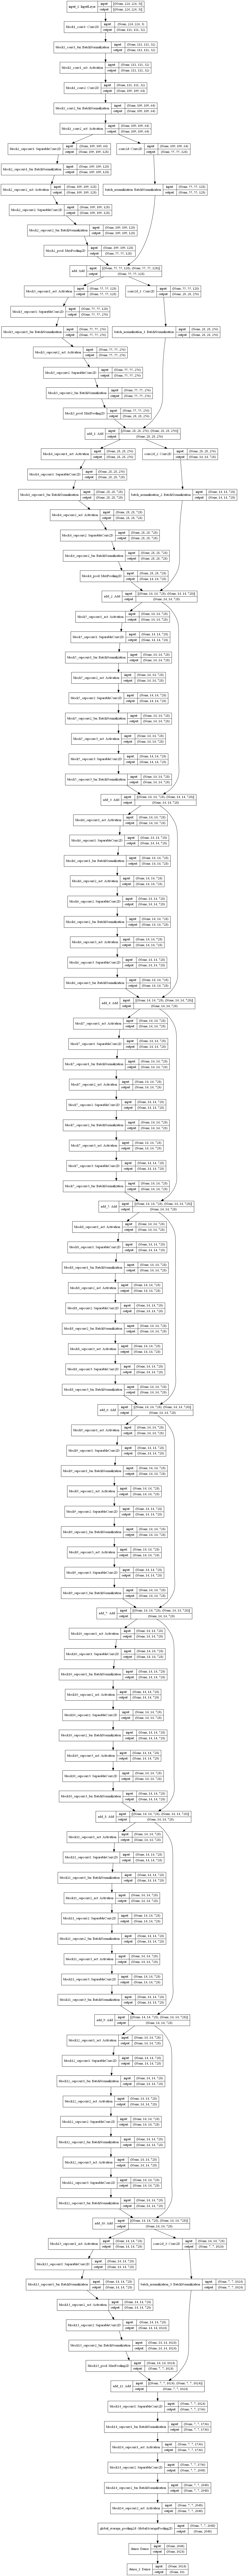

In [6]:
# モデルを画像として出力
from keras.utils import plot_model
plot_model(model,show_shapes=True,to_file='Xception.png')

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validation_datagen=ImageDataGenerator()

train_datagen.fit(x_train)
validation_datagen.fit(x_valid)

train_generator=train_datagen.flow(
    x_train,y_train,
    batch_size=100,
    shuffle=True
)

validation_generator=validation_datagen.flow(
    x_valid,y_valid,
    batch_size=100,
    shuffle=True
)

hist=model.fit_generator(train_generator,
                         epochs=50,
                         verbose=1,
                         validation_data=validation_generator)

C:\Users\yudai\anaconda3\envs\py38-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
400/400 [==============================] - 253s 617ms/step - loss: 1.6267 - accuracy: 0.4182 - val_loss: 1.0942 - val_accuracy: 0.6879
Epoch 2/50
400/400 [==============================] - 156s 389ms/step - loss: 0.7335 - accuracy: 0.7617 - val_loss: 0.6206 - val_accuracy: 0.7924
Epoch 3/50
400/400 [==============================] - 23s 57ms/step - loss: 0.5999 - accuracy: 0.8024 - val_loss: 0.7314 - val_accuracy: 0.7693
Epoch 4/50
400/400 [==============================] - 23s 56ms/step - loss: 0.5142 - accuracy: 0.8303 - val_loss: 0.5479 - val_accuracy: 0.8199
Epoch 5/50
400/400 [==============================] - 23s 57ms/step - loss: 0.4416 - accuracy: 0.8549 - val_loss: 0.5201 - val_accuracy: 0.8236
Epoch 6/50
400/400 [==============================] - 23s 56ms/step - loss: 0.4031 - accuracy: 0.8638 - val_loss: 0.6515 - val_accuracy: 0.8022
Epoch 7/50
400/400 [==============================] - 23s 57ms/step - loss: 0.3653 - accuracy: 0.8798 - val_loss: 0.5901 - val_accur

In [5]:
def plot_loss(history):
    """エポックごとの損失関数をプロットする関数
    
    Args:
    history : fittingの履歴
    
    Returns:
    None
    """
    # 損失関数の履歴を取得
    loss_train = history.history["loss"]
    loss_val = history.history["val_loss"]

    # 損失関数をプロット
    epochs=range(1,len(history.history["loss"])+1)
    plt.figure(facecolor="white")
    plt.plot(epochs,loss_train,label="Training loss")
    plt.plot(epochs,loss_val,label="Validation loss")
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
def plot_acc(history):
    """エポックごとの正解率をプロットする関数
    
    Args:
    history : fittingの履歴
    
    Returns:
    None
    """
    acc_train = history.history['accuracy']
    acc_val = history.history['val_accuracy']
    epochs = range(1,len(history.history["accuracy"])+1)
    plt.figure(facecolor="white")
    plt.plot(epochs, acc_train, 'g', label='Training accuracy')
    plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

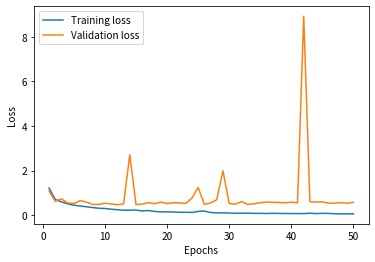

In [6]:
# 損失関数の描画
plot_loss(hist)

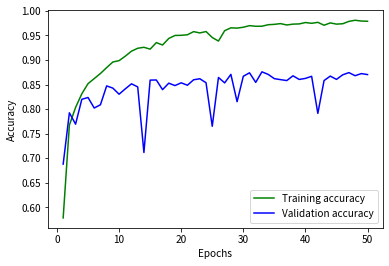

In [7]:
# 正解率を描画
plot_acc(hist)

In [8]:
# modelの評価
test_datagen=ImageDataGenerator()
test_datagen.fit(x_test)
test_generator=test_datagen.flow(
    x_test,y_test,
    batch_size=100,
    shuffle=True
)

scores = model.evaluate(test_generator)

100/100 [==============================] - 2s 17ms/step - loss: 0.5791 - accuracy: 0.8651
